Team FacialKeyPoints:  Vyas Swaminathan, Sandip Patel, Stacia Choe

In this baseline python notebook, we loaded the dataset from Kaggle and attempted training with 
a. a 2 layer convnet with one fully connected layer
b. a 4 layer convnet with one fully connected layer
c. a 2 layer convnet with two fully connected layers.

We also performed data augmentation by flipping the images horizontally, as well as applying histogram normalization, to increase the size of the training data.

In [1]:

# Reference-https://www.tensorflow.org/get_started/mnist/pros

# Loading required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import matplotlib.pyplot as plt
import scipy.signal



# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

np.random.seed(0)


In [2]:
#flips images horizontally
def flip_images(inputdata):
    data=inputdata.copy()
    origcols = list(data.columns)
    newcols = [item for item in origcols]
    
    for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: -x)
    #print data.head()
    
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    
    for (a,b) in flip_indices:
        newcols[a],newcols[b] = newcols[b],newcols[a]

    colmap = {}
    for i in range(len(newcols)):
        colmap[origcols[i]]=newcols[i]
    
    data = data[newcols]
    data.rename(columns = colmap,inplace=True)
    #print data.head()

    
    data["Image"] = data["Image"].apply(lambda x: np.fliplr(x.reshape((96,96))).flatten())

    return data


In [3]:
import collections

# helper function to create histogram
def histogram(L):
    d = {}
    for x in L:
        if x in d:
            d[x] += 1
        else:
            d[x] = 1
    return d

# applies histogram normalization, which scales pixel value by its cdf
# we are using the function  (cdf(pixel) - min_cdf) / (imagesize - 1)
def histnorm(inputdata):
    data=inputdata.copy()

    for i in range(len(data)) :
        img = data["Image"][i]
        h1 = histogram(img)
        
        # sort the hist of pixels by their pixel values
        # we will do this to sum up their values to create cdf array
        ho = collections.OrderedDict(sorted(h1.items()))
        ho_cdf = ho.copy()
        current_sum = 0
        min_cdf = -999
        for key, value in ho_cdf.items():
            
            # calculate cdf.  sum up probabilities of all lower-valued pixels
            current_sum += value
            
            # get the minimum cdf for all pixels
            if (min_cdf < 0) :
                min_cdf = current_sum
                
            ho_cdf[key] = current_sum
        for j in range(len(img)) :
            pixval = img[j]
            
            # scale by (image_size - 1) = 9215
            new_pix_val = (ho_cdf[pixval] - min_cdf) / 9215
            img[j] = new_pix_val
        data["Image"][i] = img
    return data

In [4]:
# Create iterator to deliver data & labels in sets of batchSize
def imgs_iterator(data,labels,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
            batchIndices = indices[i:i+batchSize]
            yield np.stack(data[batchIndices]),labels[batchIndices],len(batchIndices)

# Same as imgs_iterator but for test data (don't return labels)
def imgs_iterator_predict(data,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
        batchIndices = indices[i:i+batchSize]
        
        yield np.stack(data[batchIndices]),len(batchIndices)

# Make predictions according to formula "y = Wx + b" for data set 
# Similar in form to training loop
def make_predictions(data,batch_size):
    results = data.copy()
    predictions_mb=[]
    # Iterate by batch size
    iter_test = imgs_iterator_predict(data,batch_size)
    try:
        next_batch =iter_test.__next__()
        while next_batch!=None:
            
            # Load next batch
            mini_batch,batch_size = next_batch
            
            # Reshape
            mini_batch = np.reshape(mini_batch,(batch_size,9216))
            
            # Make prediction with input data and dropout 
            feed_dict = {x: np.stack(mini_batch), keep_prob: 1.0}
            predictions = y.eval(feed_dict)
            predictions_mb.append(predictions)
            
            next_batch =iter_test.__next__()
    except StopIteration:
        next_batch=None
    results = pd.DataFrame(np.vstack(predictions_mb))
    
    return results

# Generate reports for submission
def generate_results(result):
    submission = pd.read_csv('SampleSubmission.csv')
    IdLookup = pd.read_csv('IdLookupTable.csv')
    IdLookupDict = IdLookup.set_index('RowId').T.to_dict('list')

    
    
    result.columns = dev.columns[0:30]
    output = pd.concat([test["ImageId"],result_test],axis=1)
    
    RowId = np.asarray(submission["RowId"],dtype=int)
    for row in RowId:
        r = IdLookupDict[row][0]-1
        c =IdLookupDict[row][1]
        submission.loc[row-1,"Location"]= max(0,min(96,(output.loc[r,c]*48+48)))
    
    
    submission.to_csv("submission.csv",index=False)


In [5]:
# Loading the test and raw training datasets
# Raw is 7049X31.  7049 training examples, 30 columns of facial feature x &y locations, 1 column for list of image pixel values
# Test is 1783X2. 1783 test examples, 1 column for image id, 1 column for list of image pixel values
raw = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')


# Converting image data into numpy arrays and scaling the images
raw["Image"] = raw["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)
test["Image"] = test["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)

for col in raw.columns.get_level_values(0)[0:30]:
    raw[col] = raw[col].apply(lambda x: (x-48)/48)


In [6]:
# Dropping training & test cases with na values since they will prevent the model from training correctly.
# Possibly revisit this to come up with a better approach
raw.dropna(inplace=True)
test.dropna(inplace=True)


# After removing the cases with 'na', re-shuffle (the training set) and re-do indexing
raw = raw.sample(frac=1) 
raw.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [7]:
#Augment the dataset by adding flipped and histogram normalized images
fi = flip_images(raw)
cr = histnorm(raw)
raw = pd.concat([raw,fi],axis=0)
raw = pd.concat([raw,cr],axis=0)
raw = raw.sample(frac=1)
raw.reset_index(inplace=True,drop=True)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# Our training data set has 6420 examples at this point.  
# Allocate 80% for training and 20% for development.
train_size = int(raw.shape[0]*.8)
train = raw.iloc[0:train_size,:]
dev = raw.iloc[train_size:raw.shape[0],:]

# Re-index
train.reset_index(inplace=True,drop=True)
dev.reset_index(inplace=True,drop=True)

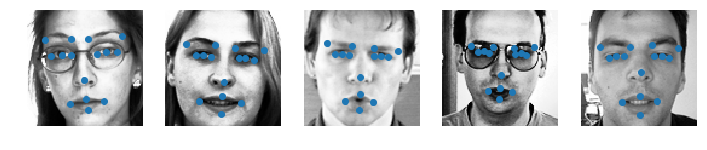

In [9]:
# Visualize 5 example images:
def plot_images(num_images,inputdata, inputresult=None,training=True):
    data=inputdata.copy()
    if inputresult is not None:
        result = inputresult.copy()
    plt.figure(figsize=(12,4))
    
    for col in data.columns.get_level_values(0)[0:30]:
            data[col] = data[col].apply(lambda x: x*48+48)
    
    if training==False:
        for col in result.columns.get_level_values(0)[0:30]:
            result[col] = result[col].apply(lambda x: x*48+48)
    
    
    for i in range(num_images):
        
        # Every example has 30 facial features and 1 column with a 9216-length list of pixel values of image
        # take the 9216 list of pixels and reshape into 96X96 image for viewing
        img =  np.reshape(data.ix[i:i,"Image"].values[0],(96,96))
        plt.subplot(1,num_images,i+1)
        plt.axis('off')
        
        # Show the facial image
        plt.imshow(img,cmap='Greys_r')
        
        
    

        # Get x & y values for the facial keypoints and overlay on the face
        x_values = np.asarray(data[data.columns.get_level_values(0)[0:30:2]])
        y_values = np.asarray(data[data.columns.get_level_values(0)[1:30:2]])
        plt.scatter(x_values[i],y_values[i])
        
        # If we are not using training data, then show our predicted facial keypoints with red x's
        if training==False:
            
        
            
            rx_values = np.asarray(result[result.columns.get_level_values(0)[0:30:2]])
            ry_values = np.asarray(result[result.columns.get_level_values(0)[1:30:2]])
            plt.scatter(rx_values[i],ry_values[i],marker="x",color='r')
            

plot_images(5,train)

In [10]:

# Convert the pixel arrays and facial feature locations in train/dev/test into numpy-array representation
train_data = train["Image"].as_matrix()
train_labels = np.asarray(train[train.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

dev_data = dev["Image"].as_matrix()
dev_labels = np.asarray(dev[dev.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

test_data = test["Image"].as_matrix()

**Model1**

In the section below, an initial baseline model has been created with 2 conv+relu+maxpool layers and one fully connected layer

Running the model without dropout resulted in overfitting. Through crossvalidation, a dropout value of .25 was chosen to ensure generalization. 

The RMSE of this model using the test dataset was 4.44 on the Kaggle leaderboard

In [14]:
# Try 2-convolutional-layers, 1 fully connected

mini_batch_size=400
epochs = 300

epoch=[i for i in range(epochs)]


# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')



# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])


# Weights will be 4D tensor of size 5x5x1x32 from truncated normal, 32-length array bias of constant 0.1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])


# x_image is in shape [batch, in_height, in_width, in_channels] ~ [-1, 96, 96, 1]
# W_conv1 is in shape [filter_height, filter_width, in_channels, out_channels] ~ [5,5,1,32]
# conv2d flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels]
#      ~ [5*5*1, 32] ~ [25, 32]
# Apply rectifier relu function
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# Perform reduction.  h_conv1 is [?,96,96,32] with strides [1,2,2,1]
# Returns a 48*48 image with 32 filters
h_pool1 = max_pool_2x2(h_conv1)

# 2nd convolutional layer - will return 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# Flatten resulting image to apply relu activation
h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])

# Fully connected layer
W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Apply dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Determine prediction function "y=Wx+b"
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define loss function, try minimize with AdamOptimizer (more efficient than gradient descent)
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-3).minimize(error)

# Track train/dev errors for plotting
train_error = []
dev_error = []


with tf.Session() as sess:
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate over training data in increments of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape 
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Determine accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.25})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+" ="+str(train_accuracy))
        train_error.append(train_accuracy)

    
        # Measure accuracy with trained NN on dev data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)

        # Get batch of 20 from dev data
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch

        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))

        # Calculate accuracy
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
    
        dev_error.append(dev_accuracy)


    # Generate predictions for display
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    sess.close()


RMSE for Epoch 0 =0.38333
RMSE for dev set =0.374931
RMSE for Epoch 1 =0.265705
RMSE for dev set =0.258469
RMSE for Epoch 2 =0.203235
RMSE for dev set =0.196358
RMSE for Epoch 3 =0.166357
RMSE for dev set =0.149589
RMSE for Epoch 4 =0.12002
RMSE for dev set =0.110759
RMSE for Epoch 5 =0.094349
RMSE for dev set =0.109216
RMSE for Epoch 6 =0.0858088
RMSE for dev set =0.093599
RMSE for Epoch 7 =0.0852305
RMSE for dev set =0.0875803
RMSE for Epoch 8 =0.0879721
RMSE for dev set =0.0783115
RMSE for Epoch 9 =0.0789607
RMSE for dev set =0.073304
RMSE for Epoch 10 =0.0771924
RMSE for dev set =0.0726454
RMSE for Epoch 11 =0.0737385
RMSE for dev set =0.0760757
RMSE for Epoch 12 =0.0803565
RMSE for dev set =0.0774617
RMSE for Epoch 13 =0.0694333
RMSE for dev set =0.0681635
RMSE for Epoch 14 =0.0752646
RMSE for dev set =0.0676731
RMSE for Epoch 15 =0.0727809
RMSE for dev set =0.0763319
RMSE for Epoch 16 =0.0687122
RMSE for dev set =0.0681406
RMSE for Epoch 17 =0.0704809
RMSE for dev set =0.0694932


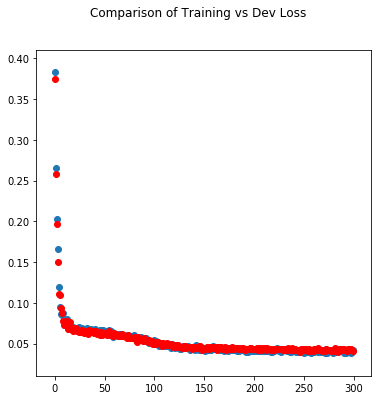

In [15]:

# Plot train/dev errors by epoch

plt.figure(figsize=(6,6))
plt.suptitle("Comparison of Training vs Dev Loss")
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


Based on the plots for training loss(blue) vs the test loss(red), we can conclude that our model does not overfit the data. However, there may be an opportunity to reduce the model's bias by adding additional layers.

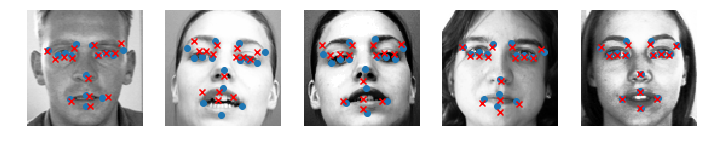

In [16]:
# Plot our predictions
plot_images(5,inputdata =dev,inputresult=result_dev,training=False)
#

**Model 2**
In an attempt to reduce the previous model's bias, 2 additional convolutional layers were added.

In [16]:
# Try 4 convolutional layers, 1 fully connected

mini_batch_size=400
epochs = 100

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Same as previous exercise, next return a 12*12 image with 128 filters
W_conv3 = weight_variable([3, 3, 64, 128])
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Fourth convolutional layer, returns a 6*6 image with 256 filters
W_conv4 = weight_variable([3, 3, 128, 256])
b_conv4 = bias_variable([256])
h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
h_pool4 = max_pool_2x2(h_conv4) #returns a 6*6 image with 256 filters

# Flatten resulting image for matrix multiplication
h_pool4_flat = tf.reshape(h_pool4, [-1, 6*6*256])
# Fully connected layer
W_fc1 = weight_variable([6 * 6 * 256, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)

# Dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Prediction y=xW+b
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define RMSE loss function, minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-3).minimize(error)


epoch=[i for i in range(epochs)]

# Collect train and dev error magnitudes for visualization
train_error = []
dev_error = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate over training data in steps of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.25})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
        # Test accuracy on the unseen (dev) data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20 from dev
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    # Generate predictions for train/dev/test
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    
    sess.close()

RMSE for Epoch 0 =0.353021
RMSE for dev set =0.376787
RMSE for Epoch 1 =0.309878
RMSE for dev set =0.295827
RMSE for Epoch 2 =0.26998
RMSE for dev set =0.276997
RMSE for Epoch 3 =0.251195
RMSE for dev set =0.237433
RMSE for Epoch 4 =0.209248
RMSE for dev set =0.209637
RMSE for Epoch 5 =0.215397
RMSE for dev set =0.185225
RMSE for Epoch 6 =0.187711
RMSE for dev set =0.168796
RMSE for Epoch 7 =0.154552
RMSE for dev set =0.180032
RMSE for Epoch 8 =0.153622
RMSE for dev set =0.18591
RMSE for Epoch 9 =0.128123
RMSE for dev set =0.15698
RMSE for Epoch 10 =0.129518
RMSE for dev set =0.112931
RMSE for Epoch 11 =0.153378
RMSE for dev set =0.128774
RMSE for Epoch 12 =0.133124
RMSE for dev set =0.141931
RMSE for Epoch 13 =0.118184
RMSE for dev set =0.121077
RMSE for Epoch 14 =0.122447
RMSE for dev set =0.109324
RMSE for Epoch 15 =0.112557
RMSE for dev set =0.108762
RMSE for Epoch 16 =0.102733
RMSE for dev set =0.104861
RMSE for Epoch 17 =0.119742
RMSE for dev set =0.112101
RMSE for Epoch 18 =0.11

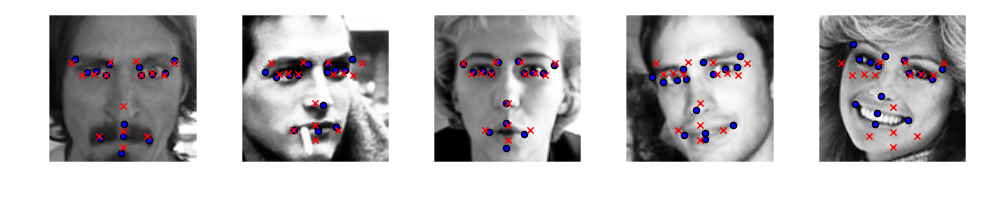

In [23]:
# Plot predictions from dev data
plot_images(5,inputdata =dev,inputresult=result_dev,training=False)

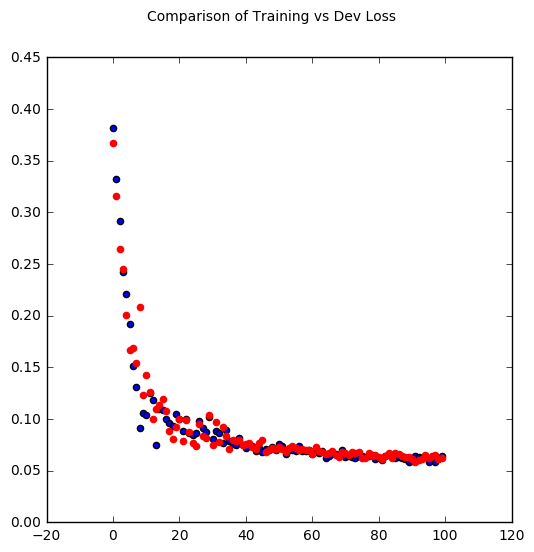

In [24]:

# Plot train/dev errors by epoch
plt.figure(figsize=(6,6))
plt.suptitle("Comparison of Training vs Dev Loss")
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


Adding two additional convolutional layers has not changed the test/dev loss significantly, but did give us our best kaggle score of 4.30.

In [13]:
# Try 2 convolutional layers, 2 fully connected layers

mini_batch_size=400
epochs = 400


# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])


# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters

# Same as previous exercise, next return a 12*12 image with 128 filters
W_conv2a = weight_variable([5, 5, 64, 128])
b_conv2a = bias_variable([128])
h_conv2a = tf.nn.relu(conv2d(h_pool2, W_conv2a) + b_conv2a)
h_pool2a = max_pool_2x2(h_conv2a) #returns a 12*12 image with 128 filters


# Fully connected layer
W_fc1 = weight_variable([12 * 12 * 128, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2a, [-1, 12*12*128])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout to prevent overfit
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Fully connected layer
W_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# Prediction function
W_fc3 = weight_variable([1024, 30])
b_fc3 = bias_variable([30])
y = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

# Define RMSE error, minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-4).minimize(error)

epoch=[i for i in range(epochs)]

# Track train/dev errors for plotting
train_error = []
dev_error = []

# GPU settings
config = tf.ConfigProto()
config.gpu_options.allow_growth=True


with tf.Session(config=config) as sess:
    
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate by batch size
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate acccuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of training data
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.2})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
    
        # Determine accuracy on our dev data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    #Predictions on train/dev/test for plotting
    #result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    
    sess.close()

RMSE for Epoch 0 =7.76226
RMSE for dev set =6.72068
RMSE for Epoch 1 =0.810855
RMSE for dev set =0.688001
RMSE for Epoch 2 =0.49249
RMSE for dev set =0.488881
RMSE for Epoch 3 =0.465038
RMSE for dev set =0.460179
RMSE for Epoch 4 =0.437772
RMSE for dev set =0.436461
RMSE for Epoch 5 =0.415635
RMSE for dev set =0.409803
RMSE for Epoch 6 =0.388837
RMSE for dev set =0.386464
RMSE for Epoch 7 =0.367085
RMSE for dev set =0.364775
RMSE for Epoch 8 =0.347508
RMSE for dev set =0.34339
RMSE for Epoch 9 =0.326746
RMSE for dev set =0.32358
RMSE for Epoch 10 =0.303897
RMSE for dev set =0.303852
RMSE for Epoch 11 =0.287347
RMSE for dev set =0.286219
RMSE for Epoch 12 =0.273084
RMSE for dev set =0.269371
RMSE for Epoch 13 =0.255939
RMSE for dev set =0.250774
RMSE for Epoch 14 =0.243139
RMSE for dev set =0.240273
RMSE for Epoch 15 =0.225447
RMSE for dev set =0.225843
RMSE for Epoch 16 =0.215375
RMSE for dev set =0.21081
RMSE for Epoch 17 =0.203282
RMSE for dev set =0.2009
RMSE for Epoch 18 =0.190228


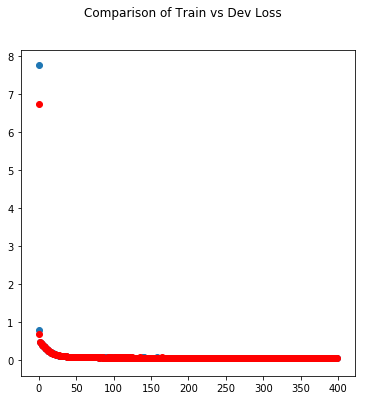

In [14]:
# Plot training and dev errors by epoch
plt.figure(figsize=(6,6))
plt.suptitle("Comparison of Train vs Dev Loss")
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


Adding an additional fully connected layer does not seem to have a huge effect on the training and dev loss. The performance of this model remains comparable to the two models preceding it.  This NN gave a kaggle score of 4.38.


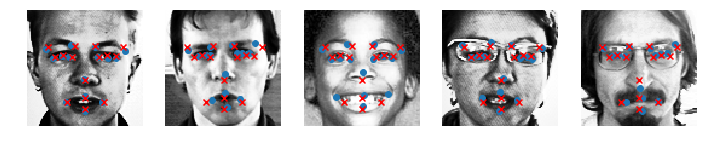

In [15]:
# Plot predicted facial keypoints from dev_data
plot_images(5,dev,result_dev,False) 

In [16]:
# Submission
generate_results(result_test)

| Model 1| Layers                       |  Epochs |   Training Loss  |  Dev Loss  |  Expected RMSE   |
|--------|------------------------------|---------|------------------|------------|------------------|
|   1    | 2 Conv+ReLU+MaxPool, 1 FC    |    300  |    ~.040         |    ~.040   |      1.92        |
|   2    | 4 Conv+ReLU+MaxPool, 1 FC    |    100  |    ~.060         |    ~.060   |      2.88        |
|   3    | 2 Conv+ReLU+MaxPool, 2 FC    |    400  |    ~.060         |    ~.060   |      2.88        ||




**Future Work**
1. Try to use all the available training data by potentially fitting 2 neural nets - one for the 4 keypoints present in all the training data, and one the remaining keypoints
2. Try additional data augmentation techniques to increase the size of the training data. eg. Rotations
